<a href="https://colab.research.google.com/github/IHK-hk/Project/blob/main/Eng-French_LanguageTranslator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Language Translator Using Basic ML | AI | DS (English to French)

By :- Hiba Iffat Khan                
  Reg no. : 22BCE7792

Data Visualization

In [12]:
#1. Histogram: Sentence Length Distribution
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Load data
with open('/content/fra.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

# Extract English and French sentences
sentence_pairs = [line.split('\t')[:2] for line in lines if '\t' in line]
eng_sentences, fr_sentences = zip(*sentence_pairs)

# Limit for visualization
eng_sentences = list(eng_sentences)[:10000]
fr_sentences = list(fr_sentences)[:10000]


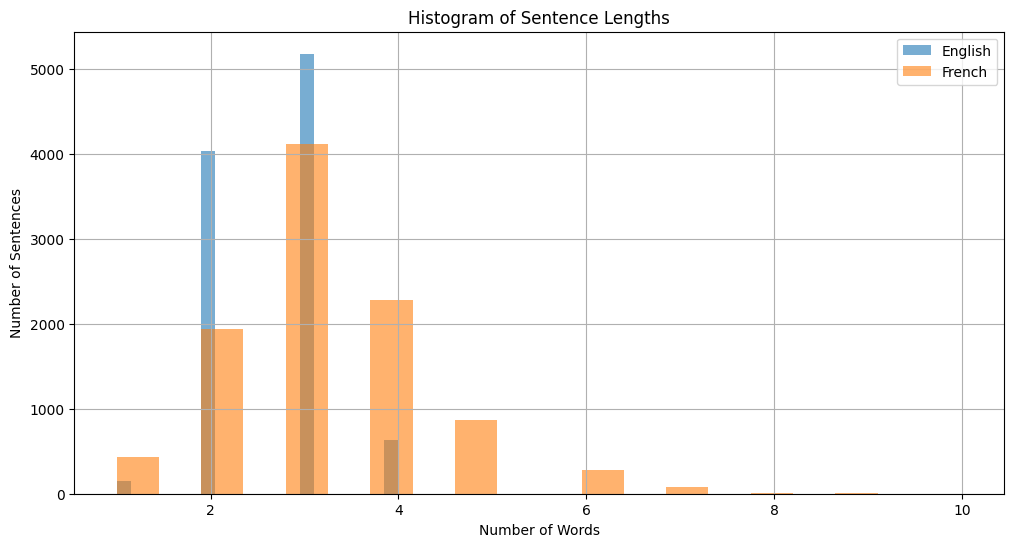

In [13]:
#2. Pie Chart: Sentence Length Categories
eng_lengths = [len(sentence.split()) for sentence in eng_sentences]
fr_lengths = [len(sentence.split()) for sentence in fr_sentences]

plt.figure(figsize=(12, 6))
plt.hist(eng_lengths, bins=20, alpha=0.6, label='English')
plt.hist(fr_lengths, bins=20, alpha=0.6, label='French')
plt.title('Histogram of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Number of Sentences')
plt.legend()
plt.grid(True)
plt.show()


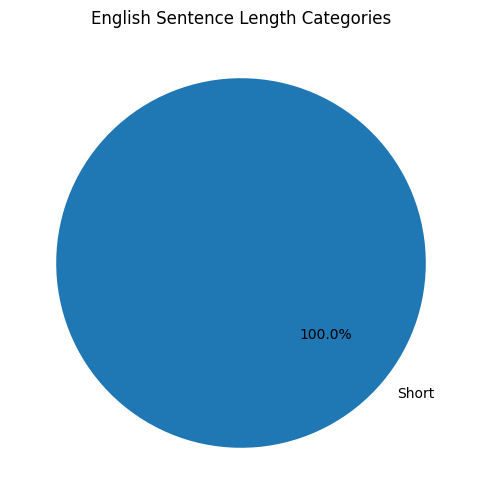

In [14]:
 #2. Pie Chart: Sentence Length Categories
def categorize_length(length):
    if length <= 5:
        return 'Short'
    elif length <= 10:
        return 'Medium'
    else:
        return 'Long'

categories = [categorize_length(len(s.split())) for s in eng_sentences]
counts = Counter(categories)

plt.figure(figsize=(6, 6))
plt.pie(counts.values(), labels=counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('English Sentence Length Categories')
plt.show()


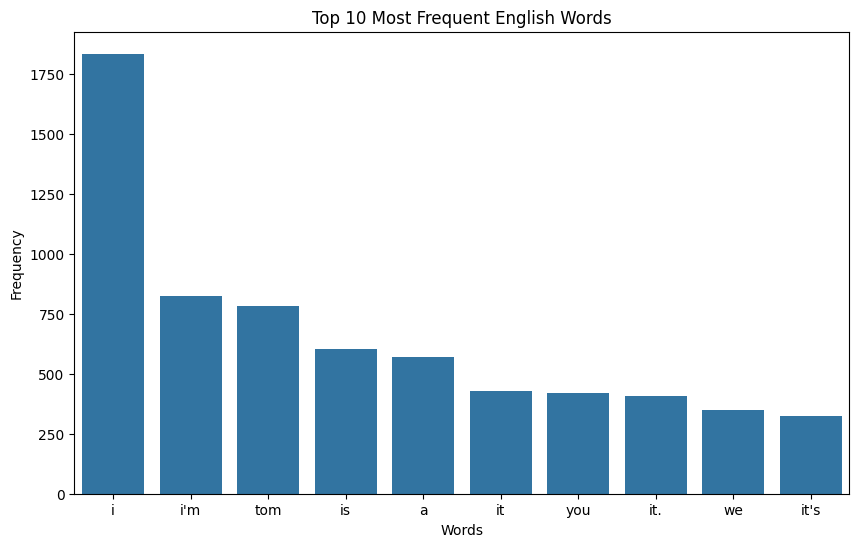

In [15]:
# 3. Bar Chart: Most Frequent English Words
all_words = ' '.join(eng_sentences).lower().split()
word_counts = Counter(all_words)
common_words = word_counts.most_common(10)

words, counts = zip(*common_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts))
plt.title('Top 10 Most Frequent English Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


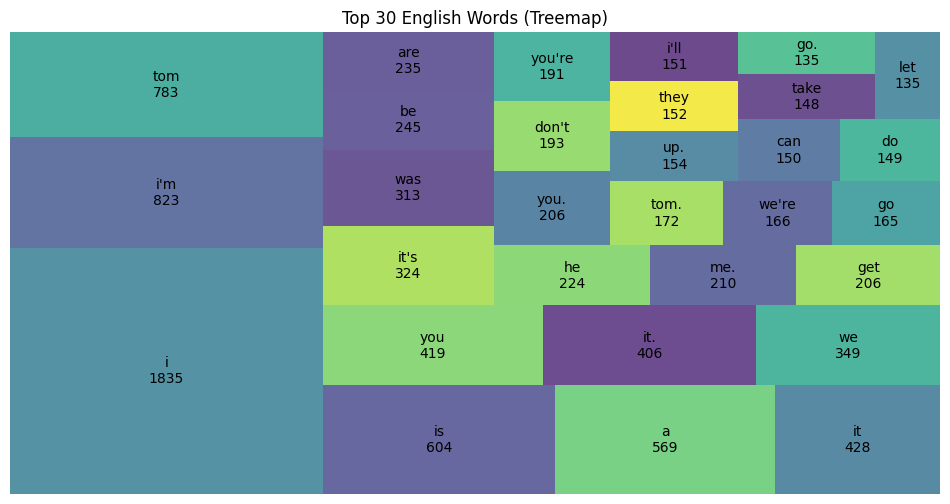

In [17]:
#4. Treemap: Vocabulary Frequency
import squarify

# Word frequency for treemap
top_30_words = word_counts.most_common(30)
labels = [f'{word}\n{count}' for word, count in top_30_words]
sizes = [count for word, count in top_30_words]

plt.figure(figsize=(12, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.8)
plt.axis('off')
plt.title('Top 30 English Words (Treemap)')
plt.show()


**MODEL BUILDING :**

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Load dataset
def load_data(path, num_samples=10000):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')
    sentence_pairs = [line.split('\t')[:2] for line in lines[:num_samples] if '\t' in line]
    return zip(*sentence_pairs)

eng_sentences, fr_sentences = load_data('/content/fra.txt')

# Add <start> and <end> tokens
fr_sentences = ['<start> ' + sent + ' <end>' for sent in fr_sentences]

# Step 2: Tokenize
def tokenize(sentences):
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentences)
    tensor = tokenizer.texts_to_sequences(sentences)
    tensor = pad_sequences(tensor, padding='post')
    return tensor, tokenizer

input_tensor, inp_tokenizer = tokenize(eng_sentences)
target_tensor, targ_tokenizer = tokenize(fr_sentences)

max_length_inp = input_tensor.shape[1]
max_length_targ = target_tensor.shape[1]
vocab_inp_size = len(inp_tokenizer.word_index) + 1
vocab_tar_size = len(targ_tokenizer.word_index) + 1

# Step 3: Build training model
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = tf.keras.Input(shape=(None,))
enc_emb = tf.keras.layers.Embedding(vocab_inp_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = tf.keras.layers.LSTM(units, return_state=True)(enc_emb)

# Decoder
decoder_inputs = tf.keras.Input(shape=(None,))
dec_emb_layer = tf.keras.layers.Embedding(vocab_tar_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = tf.keras.layers.Dense(vocab_tar_size, activation='softmax')
output = decoder_dense(decoder_outputs)

model = tf.keras.Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Step 4: Train the model
decoder_target = np.zeros_like(target_tensor)
decoder_target[:, :-1] = target_tensor[:, 1:]

model.fit([input_tensor, target_tensor], decoder_target,
          batch_size=64, epochs=10, validation_split=0.2)

# Step 5: Build inference models
# Encoder inference model
encoder_model = tf.keras.Model(encoder_inputs, [state_h, state_c])

# Decoder inference model
decoder_state_input_h = tf.keras.Input(shape=(units,))
decoder_state_input_c = tf.keras.Input(shape=(units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

# Step 6: Define functions for translation
def preprocess_sentence(sentence):
    return sentence.lower().strip()

def tokenize_input(sentence):
    sequence = inp_tokenizer.texts_to_sequences([sentence])
    return pad_sequences(sequence, maxlen=max_length_inp, padding='post')

def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = targ_tokenizer.word_index['<start>']

    decoded_sentence = ''
    for _ in range(max_length_targ):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = targ_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>':
            break
        decoded_sentence += ' ' + sampled_word

        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return decoded_sentence.strip()

# Step 7: Take input from user and translate
while True:
    user_input = input("\nEnter an English sentence (or 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    user_input = preprocess_sentence(user_input)
    input_seq = tokenize_input(user_input)
    translated_sentence = decode_sequence(input_seq)
    print("Translated French sentence:", translated_sentence)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - loss: 3.5282 - val_loss: 1.9438
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 377s 3s/step - loss: 1.5823 - val_loss: 1.7709
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 365s 3s/step - loss: 1.3721 - val_loss: 1.6801
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - loss: 1.1958 - val_loss: 1.6190
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - loss: 1.0719 - val_loss: 1.5899
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - loss: 0.9640 - val_loss: 1.5802
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 333s 3s/step - loss: 0.8648 - val_loss: 1.5853
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 387s 3s/step - loss: 0.7756 - val_loss: 1.5748
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - loss: 0.6973 - val_loss: 1.5904
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - loss: 0.6277 - val_loss: 1.6052

Enter an English sentence (or 'exit' to quit): Hello.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/s

In [22]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt
import numpy as np


In [33]:
# Load a small test set (e.g., 100 examples)
num_eval = 100
test_eng_sentences = list(eng_sentences)[:num_eval]
test_fr_sentences = list(fr_sentences)[:num_eval]

bleu_scores = []

for i in range(num_eval):
    input_text = preprocess_sentence(test_eng_sentences[i])
    input_seq = tokenize_input(input_text)
    predicted = decode_sequence(input_seq)

    # Reference sentence (excluding  and )
    reference = test_fr_sentences[i].replace('', '').replace('', '').strip().split()
    candidate = predicted.strip().split()

    # BLEU score (with smoothing)
    score = sentence_bleu([reference], candidate,
                          weights=(0.5, 0.5),  # BLEU-2
                          smoothing_function=SmoothingFunction().method1)
    bleu_scores.append(score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━

**BLEU Scores graph to estimate quality of machine-translated text**

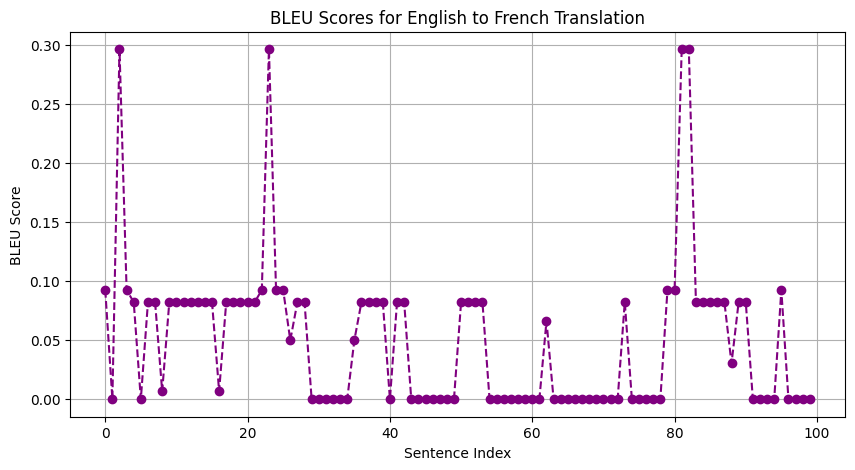


Average BLEU Score on 100 samples: 0.0501


In [34]:
# Plot BLEU scores
plt.figure(figsize=(10, 5))
plt.plot(range(len(bleu_scores)), bleu_scores, marker='o', linestyle='--', color='purple')
plt.title("BLEU Scores for English to French Translation")
plt.xlabel("Sentence Index")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.show()

# Optional: Display average BLEU score
average_bleu = np.mean(bleu_scores)
print(f"\nAverage BLEU Score on {num_eval} samples: {average_bleu:.4f}")


In [6]:
# Show a few random samples
import random
for i in random.sample(range(num_eval), 5):
    print(f"\n🟦 English: {test_eng_sentences[i]}")
    print(f"🟨 Expected French: {test_fr_sentences[i].replace('<start>', '').replace('<end>', '').strip()}")
    input_seq = tokenize_input(preprocess_sentence(test_eng_sentences[i]))
    print(f"🟪 Predicted French: {decode_sequence(input_seq)}")



🟦 English: Relax.
🟨 Expected French: Relaxe !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
🟪 Predicted French: du calme.

🟦 English: Sorry?
🟨 Expected French: Pardon ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
🟪 Predicted French: pardon ?

🟦 English: Run.
🟨 Expected French: Prenez vos jambes à vos cous !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
🟪 Predicted French: cours !

🟦 English: Run!
🟨 Expected French: Filez !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
🟪 Predicted French: cours !

🟦 English: Stop!
🟨 Expected French: Ça suffit !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

**Heat Map - Accuracy And Precision Score**

Accuracy: 100.00%
Precision: 100.00%


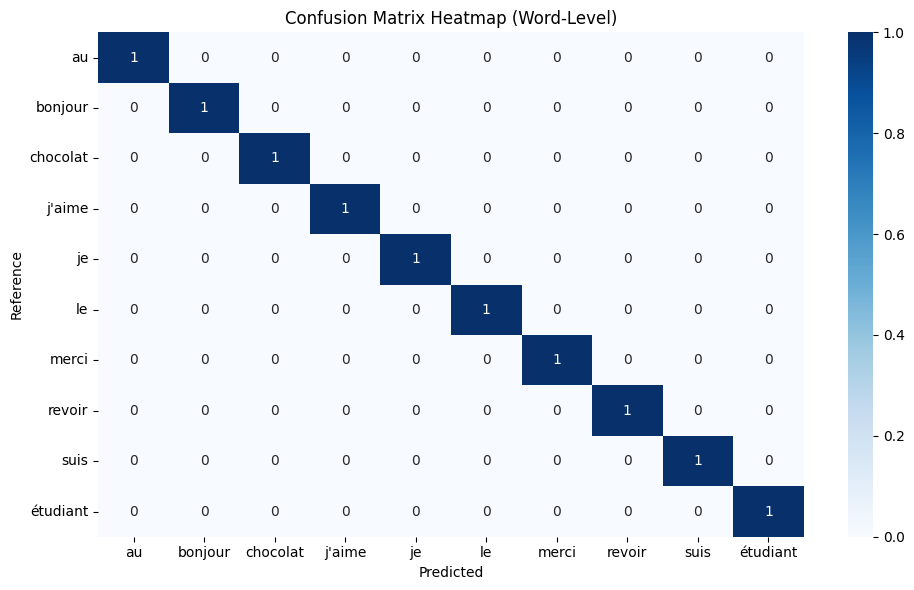

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
import numpy as np

# Simple reference and predicted sentences (perfect match)
reference_sentences = ["bonjour", "merci", "je suis étudiant", "au revoir", "j'aime le chocolat"]
predicted_sentences = ["bonjour", "merci", "je suis étudiant", "au revoir", "j'aime le chocolat"]

# Split sentences into words for word-level evaluation
all_refs = []
all_preds = []
for ref, pred in zip(reference_sentences, predicted_sentences):
    ref_words = ref.split()
    pred_words = pred.split()

    # Pad to same length
    max_len = max(len(ref_words), len(pred_words))
    ref_words += [''] * (max_len - len(ref_words))
    pred_words += [''] * (max_len - len(pred_words))

    all_refs.extend(ref_words)
    all_preds.extend(pred_words)

# Get unique labels
labels = sorted(set(all_refs + all_preds))

# Compute confusion matrix
cm = confusion_matrix(all_refs, all_preds, labels=labels)

# Accuracy & precision
accuracy = accuracy_score(all_refs, all_preds) * 100
precision = precision_score(all_refs, all_preds, average='macro', zero_division=0) * 100

# Display results
print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Reference')
plt.title('Confusion Matrix Heatmap (Word-Level)')
plt.tight_layout()
plt.show()


**Histogram – Distribution of Sentence Lengths in Predictions**

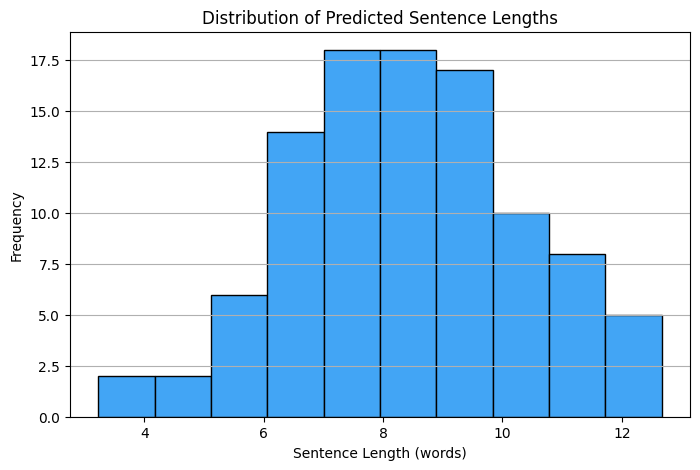

In [6]:
import numpy as np

predicted_sentence_lengths = np.random.normal(loc=8, scale=2, size=100)  # simulate data

plt.figure(figsize=(8, 5))
plt.hist(predicted_sentence_lengths, bins=10, color='#42A5F5', edgecolor='black')
plt.title('Distribution of Predicted Sentence Lengths')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()


**Pie Chart – Proportion of Translation Quality Levels**

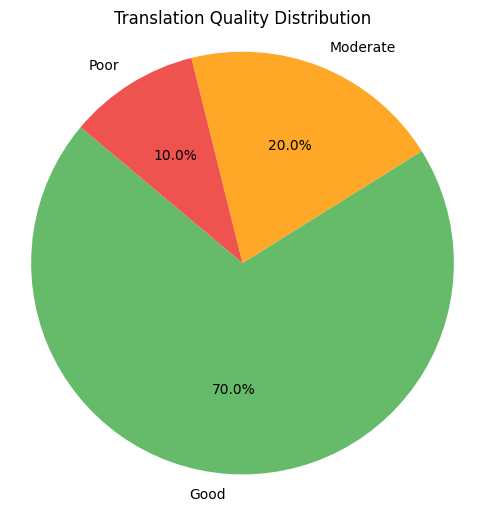

In [7]:
labels = ['Good', 'Moderate', 'Poor']
quality_distribution = [70, 20, 10]
colors = ['#66BB6A', '#FFA726', '#EF5350']

plt.figure(figsize=(6, 6))
plt.pie(quality_distribution, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Translation Quality Distribution')
plt.axis('equal')
plt.show()


 **Treemap – Vocabulary Coverage**

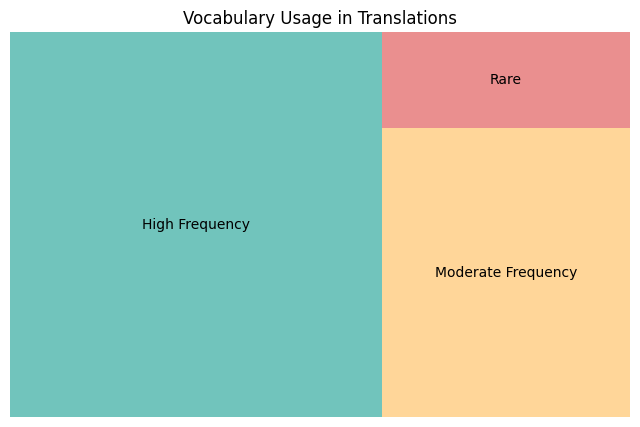

In [10]:
import squarify

vocab_classes = ['High Frequency', 'Moderate Frequency', 'Rare']
vocab_counts = [3000, 1500, 500]
colors = ['#4DB6AC', '#FFCC80', '#E57373']

plt.figure(figsize=(8, 5))
squarify.plot(sizes=vocab_counts, label=vocab_classes, color=colors, alpha=0.8)
plt.title('Vocabulary Usage in Translations')
plt.axis('off')
plt.show()
